#### Load packages 

In [35]:
print('Press `Ctrl+Enter` to load general objects')
from IPython import get_ipython
get_ipython().magic('reset -sf')
import os
import re                              #Regular expression
import pandas as pd 
import numpy as np

%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns 

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

Press `Ctrl+Enter` to load general objects


#### Read  articles information and save relevant information to csv file 

In [36]:
#Import articles data
rawfile='exportlist1727.txt' 
#rawfile='exportlist1494.txt'
#rawfile='exportlist1346.txt'
file = open(rawfile, 'r'); text = file.read(); file.close()
articlesRaw= re.split('TY  -',text)[1:]
print('Reading', len(articlesRaw), 'articles')
patterns=['AU  -','PY  -', 'T2  -','TI  -','AB  -']
keys=['Author','Year','Journal','Title','Abstract']
articles=pd.DataFrame({key: [] for key in keys})

for m, article in enumerate(articlesRaw):
    for n, pattern in enumerate(patterns):
        if n<3: #Author, Year, Jouranl
            txt=re.split(pattern,article)[1].split('\n')[0].strip() 
            if n==0:
                txt=txt.split(',')[0].strip() + ' et al.'
        else:   #Title, Abstract
            txt=re.split(pattern,article)
            if len(txt)==1:
                txt='NONE' 
            elif len(txt)==2:
                txt=txt[1].split('\n')[0].lower().strip()
                txt=re.sub(r'-', ' ',txt)           #remove '-'
                txt=re.sub('ground water','groundwater',txt)
                txt=re.sub('surface water','surfacewater',txt)
                txt=re.sub('stake holder','stakeholder',txt)
                txt=re.sub('land use','landuse',txt)
                txt=re.sub('water budget','waterbudget',txt)
                txt=re.sub('over exploitation','overexploitation',txt)
                txt=re.sub('water balance','waterbalance',txt)
                #txt=re.sub('water quality','waterquality',txt)
                #txt=re.sub('water quantity','waterquantity',txt)
                txt=re.sub('initial condition','initialcondition',txt)
                txt=re.sub('boundary conditions|boundary condition','boundarycondition',txt)
                txt=re.sub('flow directions|flow direction','flowdirection',txt)
                txt=re.sub('adaptive management','adaptivemanagement',txt)    
                txt=re.sub('gcms|gcm|glocal circulation models|glocal circulation model','GCM',txt)
                txt=re.sub('sensitivity analysis','sensitivityanalysis',txt) 
                txt=re.sub('water table','watertable',txt) 
        articles.loc[m,keys[n]]=txt 

#[2] Save and load data
file='Articles.csv'
articles.to_csv(file, index=False)
print('Done saving', articles.shape, 'matrix to',file)

Reading 1727 articles
Done saving (1727, 5) matrix to Articles.csv


In [37]:
filename='Articles.csv' 
articles=pd.read_csv(filename).fillna('none')
print('Reading',len(articles),'articles from',filename)

#Extract articels with search word and split into two periods
sw=['NONE']
keys=['Author','Year','Journal','Title','Abstract']
dfYes=pd.DataFrame({key: [] for key in keys})    
dfNo=pd.DataFrame({key: [] for key in keys}) 
countYes=0
countNo=0 
for m in range(len(articles)): 
    text=articles.loc[m,'Abstract']
    if text.count(sw[0])==0:
        if articles.loc[m,'Year']>2000:
            dfYes.loc[countYes]=articles.loc[m]
            countYes=countYes+1  
    else:
        dfNo.loc[countNo]=articles.loc[m]
        countNo=countNo+1 

        
dfYes['Year'] = dfYes.Year.astype('int64')   
dfNo['Year'] = dfNo.Year.astype('int64')   
 
#Save results to file    
periods=['Yes','No']
for n, period in enumerate(periods): 
    file='Articles'+period+'.csv'
    if n==0:
        dfYes.to_csv(file, index=False)
        print('{} relevent articles was saved to {}'.format(countYes,file))
    elif n==1:
        dfNo.to_csv(file, index=False)
        print('{} irrelevent articles was saved to {}'.format(countNo,file))

Reading 1727 articles from Articles.csv
1572 relevent articles was saved to ArticlesYes.csv
155 irrelevent articles was saved to ArticlesNo.csv


#### Collect uncertainty articles for periods 2010 and 2020

In [38]:
#Load all articles infromation file
filename='ArticlesYes.csv'
articles=pd.read_csv(filename).fillna('none')
print('Reading',len(articles),'articles from',filename)

#Extract articels with search word and split into two periods
searchword='uncertain'
keys=['Author','Year','Journal','Title','Abstract']
df2010=pd.DataFrame({key: [] for key in keys})    
df2020=pd.DataFrame({key: [] for key in keys}) 
count2010=0
count2020=0 
Y2010=0
Y2020=0
for m in range(len(articles)): 
    if articles.loc[m,'Year']<2011:
        Y2010=Y2010+1 
    else:
        Y2020=Y2020+1 
    
    text=articles.loc[m,'Abstract']
    if text.count(searchword)>0:
        if articles.loc[m,'Year']<2011:
            df2010.loc[count2010]=articles.loc[m]
            count2010=count2010+1  
        else:
            df2020.loc[count2020]=articles.loc[m]
            count2020=count2020+1  
df2010['Year'] = df2010.Year.astype('int64')   
df2020['Year'] = df2020.Year.astype('int64')   
 
#Save results to file    
periods=['UncertainC2010','UncertainC2020']
for n, period in enumerate(periods): 
    file='Articles'+period+'.csv'
    if n==0:
        df2010.to_csv(file, index=False)
        print('Period 2010 has {} of {} articles with search word `{}` saved to {}'
              .format(count2010,Y2010,searchword,file))
    elif n==1:
        df2020.to_csv(file, index=False)
        print('Period 2020 has {} of {} articles with search word `{}` saved to {}'
              .format(count2020,Y2020,searchword,file))       

Reading 1572 articles from ArticlesYes.csv
Period 2010 has 25 of 326 articles with search word `uncertain` saved to ArticlesUncertainC2010.csv
Period 2020 has 131 of 1246 articles with search word `uncertain` saved to ArticlesUncertainC2020.csv


#### Extract lines containing search word

In [46]:
#loop for all entries in the data period
Opt=0
periods=['UncertainC2010','UncertainC2020']
searchword='uncertain'

for period in periods:
    #[1] Input csv file of articles
    inputfile='Articles'+period +'.csv'
    articles=pd.read_csv(inputfile)

    #[2] Output txt file for saving extracted text 
    outputfile='ExtractedText'+period+'.csv'
    df=pd.DataFrame({key: [] for key in ['ExtractedText']}) 
    
    
    print('Reading {} articles from {} to extract text with search word `{}`'
          .format(len(articles),inputfile,searchword))
    
    #[3] Loop for all articles
    for m in range(len(articles)):
        #[3.1] Split abstract to lines
        text=articles.loc[m,'Abstract']
        text=re.sub(r'[\d]\.[\d]', r' ',text)
        text=re.sub('i\.e\.', 'ie',text)
        text=re.sub('e\.g\.', 'eg',text)
        text=re.sub('st\.', 'st',text)
        text=re.sub('b\.v\.', 'bv',text)
        text=re.sub('\. ', '\n ',text) 
        text=text.split('\n')

        #[3.2] Extract text by looping the abstract text
        txt=[]
        for n in range(len(text)):
            if text[n].count(searchword)>0:
                if Opt ==0:
                    txt.append(text[n])
                elif Opt==1:            
                    if len(text)==1:
                        txt.append(text[0])
                    elif n==0 and len(text)>1:
                        txt.append(text[0]+text[1])
                    else:
                        txt.append(text[n-1]+text[n]+text[n+1])
        df.loc[m,'ExtractedText']='.'.join(txt)

        #[3.3] Saving extracted text to a file
        df.to_csv(outputfile, index=False)
        
    print('Saving extracted text to',outputfile)

Reading 25 articles from ArticlesUncertainC2010.csv to extract text with search word `uncertain`
Saving extracted text to ExtractedTextUncertainC2010.csv
Reading 131 articles from ArticlesUncertainC2020.csv to extract text with search word `uncertain`
Saving extracted text to ExtractedTextUncertainC2020.csv


#### Word frequency 

In [40]:
#Words to count in two data periods
#'recharge','precipitation','conductivity','dispersivity','boundary',
#        'politic','economic','legisla','polic']
input=['input']
parameteric=['parameter','calibration','inverse modeling','monte carlo','markov chain monte carlo','observation']
conceptual=['model uncertainty','conceptual','structur','epistemic','geolog']
scenario=['scenario', 'climate', 'human','landuse','GCM']
words=input+parameteric+conceptual+scenario

#Output file 
periods=['UncertainC2010','UncertainC2020']
val=[0]*len(words)
wordcount =pd.DataFrame({period:val for period in periods}, index=words)

#Count keywords in two periods
for period in periods:
    #Input file
    inputfile='ExtractedText'+period+'.csv'
    ExtractedText=pd.read_csv(inputfile)
    
    #Output file
    outputfile='FreqTable'+period+'.csv'
    
    #Dataframe for counting words
    val=[0]*len(ExtractedText)
    freq=pd.DataFrame({word:val for word in words})

    #Loop for all entries in the data period
    for m in range(len(ExtractedText)):      
        #Loop for all keywords to count word frequency
        for word in words:
            if ExtractedText.loc[m,'ExtractedText'].count(word)>0:
                freq.loc[m,word]=1

    #Save freq table to file
    freq.to_csv(outputfile)
    print('Reading extracted text from',inputfile, 'and saving word frequency to',outputfile)

    #Wordcount summation for all abstracts
    wordcount[period]=freq.sum(axis='rows')
    
#Display results 
display(wordcount)

Reading extracted text from ExtractedTextUncertainC2010.csv and saving word frequency to FreqTableUncertainC2010.csv
Reading extracted text from ExtractedTextUncertainC2020.csv and saving word frequency to FreqTableUncertainC2020.csv


,UncertainC2010,UncertainC2020
input,1,9
parameter,5,23
calibration,1,4
inverse modeling,0,1
monte carlo,1,10
markov chain monte carlo,0,1
observation,0,5
model uncertainty,1,3
conceptual,1,5
structur,0,5


#### Uncertainty by type for two periods 2010 and 2020

,Input,Parameteric,Conceptual,Scenario
Period,,,,
UncertainC2010,1,7,4,4
UncertainC2020,9,27,20,32


array([[ 3, 21, 12, 12],
       [ 7, 21, 16, 25]], dtype=int64)

<IPython.core.display.Javascript object>


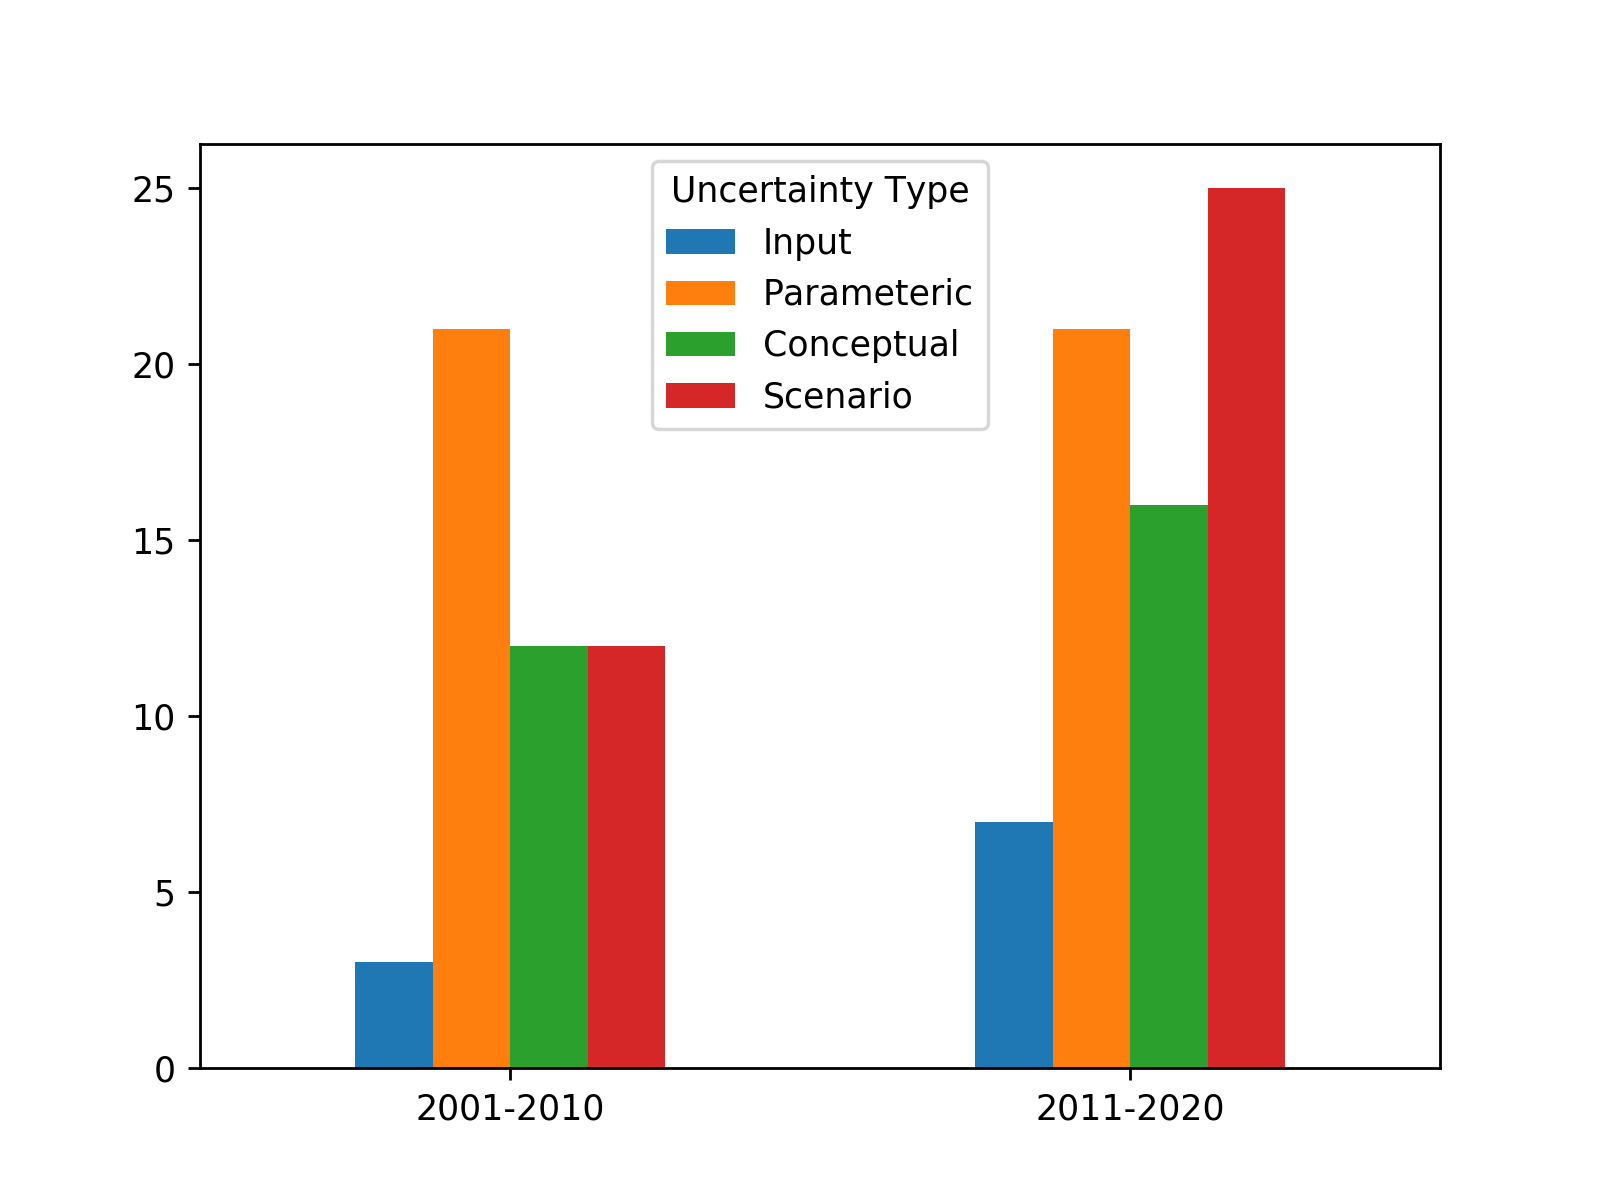

In [47]:
#Organize types of uncertainity
words=['Input','Parameteric','Conceptual','Scenario']
vals=[input,parameteric,conceptual,scenario]

#Dataframe for counting words
val=[0]*len(periods)
table = pd.DataFrame({word:val for n, word in enumerate(words)},index=periods)
table.index.name = 'Period'

#Group words by uncertainty type 
for period in periods:
    inputfile='FreqTable'+period+'.csv'
    for n,word in enumerate(words):
        freq=pd.read_csv(inputfile,skipinitialspace=True, usecols=vals[n]) 
        freq=freq.sum(axis='columns')
        freq[freq>1]=1
        table.loc[period,word]=freq.sum(axis='rows')
display(table)

# #Table for plotting
tab=np.zeros((table.shape[0],table.shape[1],),dtype=np.int64)
tab[0,:]=table.iloc[0,:]
tab[1,:]=table.iloc[1,:]

tab[0,:]=tab[0,:]/(Y2010/1000)
tab[1,:]=tab[1,:]/(Y2020/1000)

display(tab)
#Plot by period
Label=['Input','Parameteric','Conceptual','Scenario']
df=pd.DataFrame(tab,index=['2001-2010','2011-2020'], columns=pd.Index(Label,name='Uncertainty Type'))
df.plot(kind='bar',alpha=1, rot=0)

In [42]:
print('Automatic label function `al` loaded')

def al(ax,rects,xpos):
    """
    Attach a text label above each bar in *rects*, displaying its height.

    *xpos* indicates which side to place the text w.r.t. the center of
    the bar. It can be one of the following {'center', 'right', 'left'}.
    """
    
    xpos = xpos.lower()  # normalize the case of the parameter
    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0.5, 'right': 0.57, 'left': 0.43}  # x_txt = x + w*off

    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()*offset[xpos], 1.01*height,
                '{}'.format(height), ha=ha[xpos], va='bottom')

Automatic label function `al` loaded


In [43]:
#Plot by type 
ind = np.arange(len(tab[0,:]))  # the x locations for the groups
width =0.3   # the width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(ind, tab[1,:], color='SkyBlue', label='2001-2010')      
rects2 = ax.bar(ind, tab[0,:],  color='IndianRed', label='2011-2020')
ax.set_ylabel('Frequency')
ax.set_title('Types of Uncertainty')
ax.set_xticks(ind)
ax.set_xticklabels(Label)
ax.legend()
al(ax,rects1, 'center')
al(ax,rects2, 'center')
plt.show()

<IPython.core.display.Javascript object>

In [44]:
# Create stopword list:
common= ['account', 'allow', 'although', 'among', 'analysis', 'application', 'approach', 'appropriate', 'area', 'areas', 
          'aspects', 'assessing', 'assessment', 'associated', 'available', 'based', 'besides', 'challenge', 'challenges', 
          'change', 'changes', 'clallenge', 'common', 'consideration', 'considreation', 'constructing',  
          'current', 'describing', 'determining', 'developing', 'different', 'difficulties', 'due', 'effect', 
           'estimate', 'estimated', 'estimates', 'estimation', 'evaluated', 'examine', 'example', 
          'examples', 'extent', 'find',  'groundwater', 'help', 'high', 'highly', 'impacts', 'important', 
          'include', 'included', 'including', 'incorporate', 'increase', 'increases', 'individual', 'influence', 
          'involvement', 'issue', 'issues', 'key', 'lack', 'large', 'lead', 'level', 'limited', 'may', 'mean', 'method', 
          'methods', 'multiple', 'need', 'new', 'new', 'obtained', 'often', 'paper', 'problem', 'provide', 'quantify',
           'rate', 'reduce', 'regarding', 'region', 'related', 'resources', 'result', 'results', 'several', 'sgs', 
          'show', 'specific', 'study', 'subject',  'two',  'underlying', 'use', 'used', 'useful', 'using', 
          'value', 'values', 'widespread', 'will', 'within']

general=[ 'cooper','data','equation', 'equations','model', 'modelling', 'models',
        'uncertain', 'uncertainties', 'uncertainty','system', 'systems','water',]



delword=common+general
#delword=common
delword.sort()
stopwords = set(STOPWORDS)
stopwords.update(delword)
display('STOPWORDS list updated')

'STOPWORDS list updated'

In [45]:
def topicWordCloud(period, WCmaxWords):
    
    #Input file
    inputfile='ExtractedText'+period+'.csv'
    ExtractedText=pd.read_csv(inputfile)
    text=[]
    for m in range(len(ExtractedText)):
        text.append(ExtractedText.iloc[m,0])
    text=' '.join(text)
    print('Reading',inputfile)

    # Create and generate a word cloud image:
    wordcloud = WordCloud(stopwords=stopwords,max_words=nword,random_state=42,
                          background_color="white",width=1600, height=800).generate(text)
                          
    return wordcloud
                          
wordcloud = topicWordCloud(period='UncertainC2010',WCmaxWords=10)
       
                          
# fig = plt.figure()
# for i in range(n_topics):
#     ax = fig.add_subplot(2,1,i+1)
#     wordcloud = topicWordCloud(...)

#     ax.imshow(wordcloud)
#     ax.axis('off')



# nword=10   
# fig2, axs2 = plt.subplots(nrows=1, ncols=2, sharex=True)
# print(axs2[0])
# print(axs2[1])

# #Read input file containing extracted text 
# for m,period in enumerate(periods): 
#     print(m)
# 00).generate(text)
#     # Display the generated image:
    
#     ax.imshow(wordcloud, interpolation='bilinear')
#     ax.axis("off")
#     #ax.show()
#     #ax.set_title(period)
    
#     # Save the image in the img folder:
#     filename= 'CloudPlot\\'+period+str(nword)+'Word.png'
#     wordcloud.to_file(filename)
    
    




Reading ExtractedTextUncertainC2010.csv


NameError: name 'nword' is not defined

In [ ]:
# Create stopword list:
common= ['account', 'allow', 'although', 'among', 'analysis', 'application', 'approach', 'appropriate', 'area', 'areas', 
          'aspects', 'assessing', 'assessment', 'associated', 'available', 'based', 'besides', 'challenge', 'challenges', 
          'change', 'changes', 'clallenge', 'common', 'consideration', 'considreation', 'constructing',  
          'current', 'describing', 'determining', 'developing', 'different', 'difficulties', 'due', 'effect', 
           'estimate', 'estimated', 'estimates', 'estimation', 'evaluated', 'examine', 'example', 
          'examples', 'extent', 'find',  'groundwater', 'help', 'high', 'highly', 'impacts', 'important', 
          'include', 'included', 'including', 'incorporate', 'increase', 'increases', 'individual', 'influence', 
          'involvement', 'issue', 'issues', 'key', 'lack', 'large', 'lead', 'level', 'limited', 'may', 'mean', 'method', 
          'methods', 'multiple', 'need', 'new', 'new', 'obtained', 'often', 'paper', 'problem', 'provide', 'quantify',
           'rate', 'reduce', 'regarding', 'region', 'related', 'resources', 'result', 'results', 'several', 'sgs', 
          'show', 'specific', 'study', 'subject',  'two',  'underlying', 'use', 'used', 'useful', 'using', 
          'value', 'values', 'widespread', 'will', 'within']

general=[ 'cooper','data','equation', 'equations','model', 'modelling', 'models',
        'uncertain', 'uncertainties', 'uncertainty','system', 'systems','water',]



delword=common+general
#delword=common
delword.sort()
stopwords = set(STOPWORDS)
stopwords.update(delword)